<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/final_model/LeanLGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc 

import numpy as np
import pandas as pd
import lightgbm as gbm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt


In [ ]:
df = pd.read_parquet(path='/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 920 entries, customer_ID to target
dtypes: float64(891), int64(26), object(3)
memory usage: 3.1+ GB


In [ ]:
columns = df.head().dtypes
columns[columns==object]


customer_ID    object
D_63_last      object
D_64_last      object
dtype: object

In [ ]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [ ]:
X = pd.DataFrame()
Y = pd.DataFrame()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[['D_63_last', 'D_64_last']]=enc.fit(df[['D_63_last', 'D_64_last']])
df[['D_63_last', 'D_64_last']]=enc.transform(df[['D_63_last', 'D_64_last']])
df.fillna(0, inplace=True)
X= X.append(df.loc[:, ~df.columns.isin(['customer_ID', 'target'])])
Y = Y.append(df.loc[:, df.columns == 'target'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
sm = KMeansSMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
sgd = SGDClassifier()

In [ ]:
%%time
sgd.fit(X_train,y_train.to_numpy().ravel())

CPU times: user 38.8 s, sys: 2.61 s, total: 41.4 s
Wall time: 41.3 s


SGDClassifier()

In [ ]:
%%time
sfs = SelectFromModel(sgd, prefit=True)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 20 µs


In [ ]:
sfs.get_support().sum()

297

In [ ]:
X_train = sfs.transform(X_train)
X_test = sfs.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
gc.collect()

88

In [ ]:
num_leaves=[100, 200]
max_depth=[8, 9]
param_grid = dict(boosting_type=['gbdt', 'dart', 'goss'],num_leaves=num_leaves, max_depth=max_depth)

In [ ]:
clf = gbm.LGBMClassifier()

In [ ]:
grid=GridSearchCV(clf,param_grid,cv=3,scoring=('f1', 'recall'),refit='recall',return_train_score=True, verbose=10)
grid.fit(X_train,y_train.to_numpy().ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START boosting_type=gbdt, max_depth=8, num_leaves=100............
[CV 1/3; 1/12] END boosting_type=gbdt, max_depth=8, num_leaves=100; f1: (train=0.852, test=0.810) recall: (train=0.851, test=0.812) total time=  39.7s
[CV 2/3; 1/12] START boosting_type=gbdt, max_depth=8, num_leaves=100............
[CV 2/3; 1/12] END boosting_type=gbdt, max_depth=8, num_leaves=100; f1: (train=0.852, test=0.807) recall: (train=0.852, test=0.806) total time=  36.3s
[CV 3/3; 1/12] START boosting_type=gbdt, max_depth=8, num_leaves=100............
[CV 3/3; 1/12] END boosting_type=gbdt, max_depth=8, num_leaves=100; f1: (train=0.853, test=0.805) recall: (train=0.853, test=0.800) total time=  36.1s
[CV 1/3; 2/12] START boosting_type=gbdt, max_depth=8, num_leaves=200............
[CV 1/3; 2/12] END boosting_type=gbdt, max_depth=8, num_leaves=200; f1: (train=0.870, test=0.811) recall: (train=0.868, test=0.810) total time=  43.5s
[CV 2/3; 2/

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'max_depth': [8, 9], 'num_leaves': [100, 200]},
             refit='recall', return_train_score=True, scoring=('f1', 'recall'),
             verbose=10)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

0.808035968308224
{'boosting_type': 'gbdt', 'max_depth': 9, 'num_leaves': 100}


In [ ]:
clf = gbm.LGBMClassifier(boosting_type='gbdt', max_depth=9, num_leaves=100)

In [ ]:
clf.fit(X_train, y_train.values.ravel())

LGBMClassifier(max_depth=9, num_leaves=100)

In [ ]:
clf.score(X_test, y_test)

0.9015177102513537

In [ ]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 100,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
tn, fp, fn, tp

(63539, 4439, 4600, 19205)

In [ ]:
f1_score(y_test, y_pred)

0.8095007270964615

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9325    0.9347    0.9336     67978
           1     0.8123    0.8068    0.8095     23805

    accuracy                         0.9015     91783
   macro avg     0.8724    0.8707    0.8715     91783
weighted avg     0.9013    0.9015    0.9014     91783



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


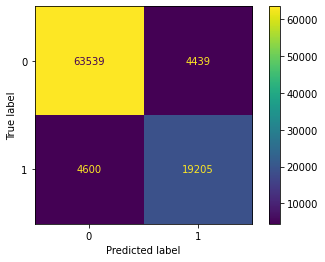

In [ ]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [ ]:
cols = sgd.feature_names_in_[sfs.get_support()]

In [ ]:
feature_importance_df = pd.DataFrame(
    {'feature': cols ,
     'importance': clf.feature_importances_})

In [ ]:
feature_importance_df.sort_values(by='importance', ascending=False).head(600)

,feature,importance
7,D_39_last,226
3,P_2_last,214
36,B_4_last,191
23,B_3_last,162
9,B_1_last,144
...,...,...
219,B_31_std,0
293,D_63_last,0
220,B_31_min,0
295,D_64_last,0
